In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Step 2: Load your data
# Upload your CSV file in Colab using the file upload feature
from google.colab import files
print("Please upload your weather dataset CSV file:")
uploaded = files.upload()

Please upload your weather dataset CSV file:


Saving weatherHistory.csv to weatherHistory.csv


In [3]:
# Get the filename
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

print(f"\n✓ Data loaded successfully")
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

# Step 3: Data Exploration
print("\n" + "="*50)
print("DATA EXPLORATION")
print("="*50)

print("\nColumn names:")
print(df.columns.tolist())


✓ Data loaded successfully
Dataset shape: (96453, 12)

First few rows:
                  Formatted Date        Summary Precip Type  Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain         9.472222   
1  2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain         9.355556   
2  2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain         9.377778   
3  2006-04-01 03:00:00.000 +0200  Partly Cloudy        rain         8.288889   
4  2006-04-01 04:00:00.000 +0200  Mostly Cloudy        rain         8.755556   

   Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  7.388889      0.89            14.1197   
1                  7.227778      0.86            14.2646   
2                  9.377778      0.89             3.9284   
3                  5.944444      0.83            14.1036   
4                  6.977778      0.83            11.0446   

   Wind Bearing (degrees)  Visibility (km)  Loud Cover  Pressure (millibars)  \
0     

In [4]:
# Step 4: Data Preprocessing
print("\n" + "="*50)
print("DATA PREPROCESSING")
print("="*50)

# Clean column names (remove extra spaces)
df.columns = df.columns.str.strip()

# Identify target variable (assuming 'Summary' is what we want to predict)
target_column = 'Summary'

# Check if target exists
if target_column in df.columns:
    print(f"\n✓ Target variable: {target_column}")
    print(f"Classes: {df[target_column].unique()}")
    print(f"\nClass distribution:")
    print(df[target_column].value_counts())
else:
    print(f"\nWarning: '{target_column}' not found. Available columns:")
    print(df.columns.tolist())

# Remove non-numeric or identifier columns
columns_to_drop = ['Formatted', 'Daily Summary']  # Add date/text columns
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n✓ Numeric features identified: {len(numeric_features)}")


DATA PREPROCESSING

✓ Target variable: Summary
Classes: ['Partly Cloudy' 'Mostly Cloudy' 'Overcast' 'Foggy'
 'Breezy and Mostly Cloudy' 'Clear' 'Breezy and Partly Cloudy'
 'Breezy and Overcast' 'Humid and Mostly Cloudy' 'Humid and Partly Cloudy'
 'Windy and Foggy' 'Windy and Overcast' 'Breezy and Foggy'
 'Windy and Partly Cloudy' 'Breezy' 'Dry and Partly Cloudy'
 'Windy and Mostly Cloudy' 'Dangerously Windy and Partly Cloudy' 'Dry'
 'Windy' 'Humid and Overcast' 'Light Rain' 'Drizzle' 'Windy and Dry'
 'Dry and Mostly Cloudy' 'Breezy and Dry' 'Rain']

Class distribution:
Summary
Partly Cloudy                          31733
Mostly Cloudy                          28094
Overcast                               16597
Clear                                  10890
Foggy                                   7148
Breezy and Overcast                      528
Breezy and Mostly Cloudy                 516
Breezy and Partly Cloudy                 386
Dry and Partly Cloudy                     86
Windy and 

In [6]:
# Step 5: Prepare features and target
print("\n" + "="*50)
print("PREPARING DATA FOR TRAINING")
print("="*50)

# Select features (all numeric columns except target if it's numeric)
X = df[numeric_features].copy()

# Handle missing values in features
if X.isnull().sum().sum() > 0:
    print(f"\n✓ Filling {X.isnull().sum().sum()} missing values with median")
    X = X.fillna(X.median())

# Encode target variable
y = df[target_column].copy()
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\n✓ Features shape: {X.shape}")
print(f"✓ Target shape: {y_encoded.shape}")
print(f"✓ Target classes: {le.classes_}")

# Step 6: Handle rare classes and split the data
print("\n" + "="*50)
print("HANDLING RARE CLASSES")
print("="*50)

# Check class distribution
class_counts = pd.Series(y_encoded).value_counts()
print(f"\nClass distribution:")
for idx, count in class_counts.items():
    print(f"  {le.inverse_transform([idx])[0]}: {count} samples")

# Identify classes with only 1 sample
rare_classes = class_counts[class_counts < 2].index.tolist()

if len(rare_classes) > 0:
    print(f"\n⚠ Found {len(rare_classes)} class(es) with only 1 sample")
    print("These will be removed to enable proper train-test split:")
    for rc in rare_classes:
        print(f"  - {le.inverse_transform([rc])[0]}")

    # Remove samples with rare classes
    mask = ~pd.Series(y_encoded).isin(rare_classes)
    X = X[mask].reset_index(drop=True)
    y_encoded_filtered = y_encoded[mask]

    print(f"\n✓ Removed {(~mask).sum()} samples")
    print(f"✓ Remaining samples: {len(X)}")
else:
    y_encoded_filtered = y_encoded
    print("\n✓ No rare classes found. All classes have 2+ samples.")

# Step 6b: Split the data
print("\n" + "="*50)
print("SPLITTING DATA")
print("="*50)

# Check if we can stratify (all classes must have at least 2 samples)
class_counts_filtered = pd.Series(y_encoded_filtered).value_counts()
can_stratify = all(class_counts_filtered >= 2)

if can_stratify:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded_filtered, test_size=0.2, random_state=42, stratify=y_encoded_filtered
    )
    print("✓ Using stratified split (maintains class proportions)")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded_filtered, test_size=0.2, random_state=42
    )
    print("✓ Using random split (stratification not possible)")

print(f"\n✓ Training set: {X_train.shape[0]} samples")
print(f"✓ Test set: {X_test.shape[0]} samples")

# Show class distribution in train and test sets
print("\nClass distribution in training set:")
train_dist = pd.Series(y_train).value_counts()
for idx, count in train_dist.items():
    print(f"  {le.inverse_transform([idx])[0]}: {count} samples")

print("\nClass distribution in test set:")
test_dist = pd.Series(y_test).value_counts()
for idx, count in test_dist.items():
    print(f"  {le.inverse_transform([idx])[0]}: {count} samples")


PREPARING DATA FOR TRAINING

✓ Features shape: (96453, 8)
✓ Target shape: (96453,)
✓ Target classes: ['Breezy' 'Breezy and Dry' 'Breezy and Foggy' 'Breezy and Mostly Cloudy'
 'Breezy and Overcast' 'Breezy and Partly Cloudy' 'Clear'
 'Dangerously Windy and Partly Cloudy' 'Drizzle' 'Dry'
 'Dry and Mostly Cloudy' 'Dry and Partly Cloudy' 'Foggy'
 'Humid and Mostly Cloudy' 'Humid and Overcast' 'Humid and Partly Cloudy'
 'Light Rain' 'Mostly Cloudy' 'Overcast' 'Partly Cloudy' 'Rain' 'Windy'
 'Windy and Dry' 'Windy and Foggy' 'Windy and Mostly Cloudy'
 'Windy and Overcast' 'Windy and Partly Cloudy']

HANDLING RARE CLASSES

Class distribution:
  Partly Cloudy: 31733 samples
  Mostly Cloudy: 28094 samples
  Overcast: 16597 samples
  Clear: 10890 samples
  Foggy: 7148 samples
  Breezy and Overcast: 528 samples
  Breezy and Mostly Cloudy: 516 samples
  Breezy and Partly Cloudy: 386 samples
  Dry and Partly Cloudy: 86 samples
  Windy and Partly Cloudy: 67 samples
  Light Rain: 63 samples
  Breezy

In [7]:
# Step 7: Feature Scaling
print("\n" + "="*50)
print("FEATURE SCALING")
print("="*50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled using StandardScaler")

# Step 8: Train the model
print("\n" + "="*50)
print("TRAINING MODEL")
print("="*50)

# Using Random Forest Classifier
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest Classifier...")
model.fit(X_train_scaled, y_train)
print("✓ Model training completed")


FEATURE SCALING
✓ Features scaled using StandardScaler

TRAINING MODEL
Training Random Forest Classifier...
✓ Model training completed


In [9]:
# Step 9: Evaluate the model
print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

# Predictions
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"\nTraining Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")



MODEL EVALUATION

Training Accuracy: 0.9179 (91.79%)
Test Accuracy: 0.5825 (58.25%)



FEATURE IMPORTANCE

Top 10 most important features:
                    feature  importance
5           Visibility (km)    0.250871
7      Pressure (millibars)    0.142394
3         Wind Speed (km/h)    0.136724
2                  Humidity    0.125338
1  Apparent Temperature (C)    0.120766
0           Temperature (C)    0.116998
4    Wind Bearing (degrees)    0.106909
6                Loud Cover    0.000000


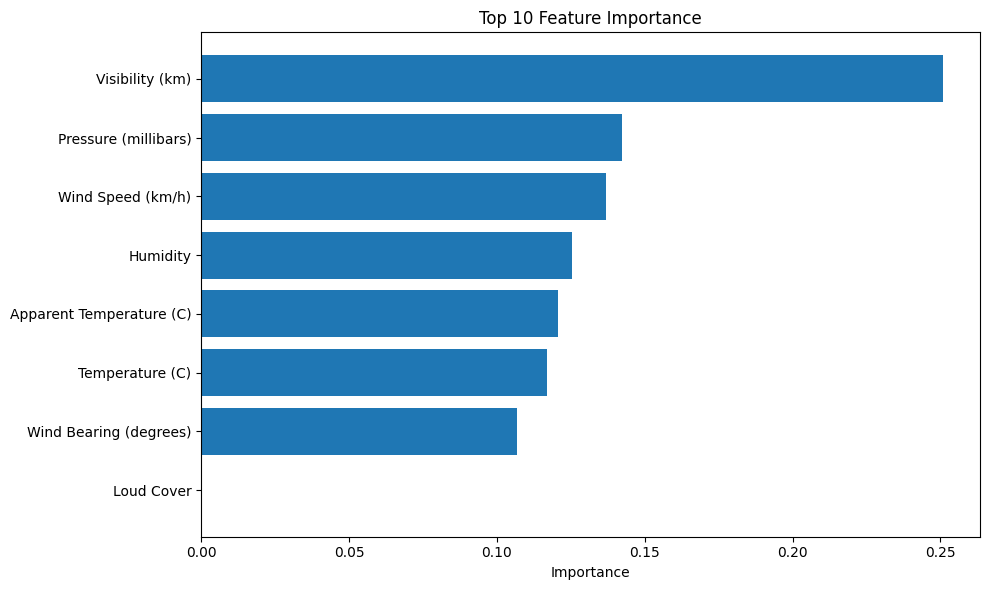

In [10]:
# Step 10: Feature Importance
print("\n" + "="*50)
print("FEATURE IMPORTANCE")
print("="*50)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


CONFUSION MATRIX


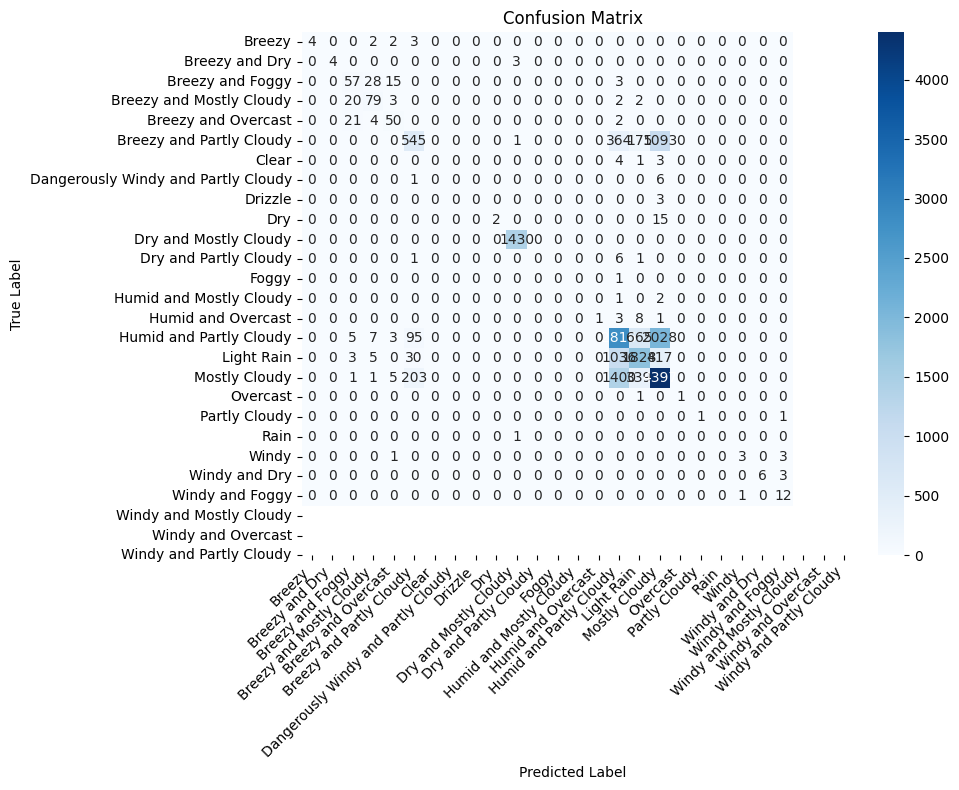

In [11]:
# Step 11: Confusion Matrix
print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [12]:
# Step 12: Save the model
print("\n" + "="*50)
print("SAVING MODEL")
print("="*50)

import pickle

# Save model
with open('weather_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("✓ Model saved as 'weather_model.pkl'")
print("✓ Scaler saved as 'scaler.pkl'")
print("✓ Label encoder saved as 'label_encoder.pkl'")


SAVING MODEL
✓ Model saved as 'weather_model.pkl'
✓ Scaler saved as 'scaler.pkl'
✓ Label encoder saved as 'label_encoder.pkl'
